Step 1: Data Preparation

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [3]:
# Load dataset
df = pd.read_csv("survey.csv")

In [4]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [5]:
# Fill missing values
df.fillna({"Statement": "", "Condition": "Unknown"}, inplace=True)

In [6]:
# Ensure "Statement" is a string before applying text processing
df["statement"] = df["statement"].astype(str)

In [7]:
# Download stopwords (if not already downloaded)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize words
    tokens = [word for word in tokens if word.isalnum()]  # Remove punctuation
    tokens = [word for word in tokens if word not in stopwords.words("english")]  # Remove stopwords
    return " ".join(tokens)

In [8]:
# Apply preprocessing
df["statement"] = df["statement"].apply(preprocess_text)

In [9]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer.fit_transform(df["statement"]).toarray()

In [10]:
# Convert categorical labels to numerical
encoder = LabelEncoder()
y = encoder.fit_transform(df["status"])

In [11]:
# Convert TF-IDF features to DataFrame
X = pd.DataFrame(X_tfidf, columns=vectorizer.get_feature_names_out())

In [12]:
# Save cleaned data for future use
df.to_csv("survey_cleaned.csv", index=False)

In [13]:
# Save vectorizer and encoder for later use
import joblib
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(encoder, "label_encoder.pkl")

['label_encoder.pkl']

Step 2: Model Development

In [14]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

c:\Users\hp\anaconda3\envs\ArogoML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Load cleaned dataset
df = pd.read_csv("survey_cleaned.csv")

In [16]:
# Reload TF-IDF features & encoded labels
X = pd.DataFrame(X_tfidf, columns=vectorizer.get_feature_names_out())  # Features
y = encoder.fit_transform(df["status"])  # Labels

In [17]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)  # Needed for ROC-AUC

In [21]:
# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)  # Needed for ROC-AUC

c:\Users\hp\anaconda3\envs\ArogoML\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
# Evaluation function
def evaluate_model(model_name, y_true, y_pred, y_prob):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    
    # ROC-AUC (for multi-class)
    roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    print(f"ROC-AUC: {roc_auc:.4f}")

In [23]:
# Evaluate models
evaluate_model("Random Forest", y_test, rf_pred, rf_prob)
evaluate_model("XGBoost", y_test, xgb_pred, xgb_prob)


Random Forest Performance:
Accuracy: 0.7100
Precision: 0.7323
Recall: 0.7100
F1-score: 0.6965
ROC-AUC: 0.9264

XGBoost Performance:
Accuracy: 0.7492
Precision: 0.7469
Recall: 0.7492
F1-score: 0.7428
ROC-AUC: 0.9406


In [24]:
# Save the best model (since XGBoost performs best)
joblib.dump(xgb_model, "mental_health_model.pkl")
print("XGBoost model saved as mental_health_model.pkl")

XGBoost model saved as mental_health_model.pkl


In [25]:
# SHAP Interpretation (for best model)
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

100%|===================| 74242/74263 [19:09<00:00]        

SHAP summary plot saved as shap_summary_plot.png


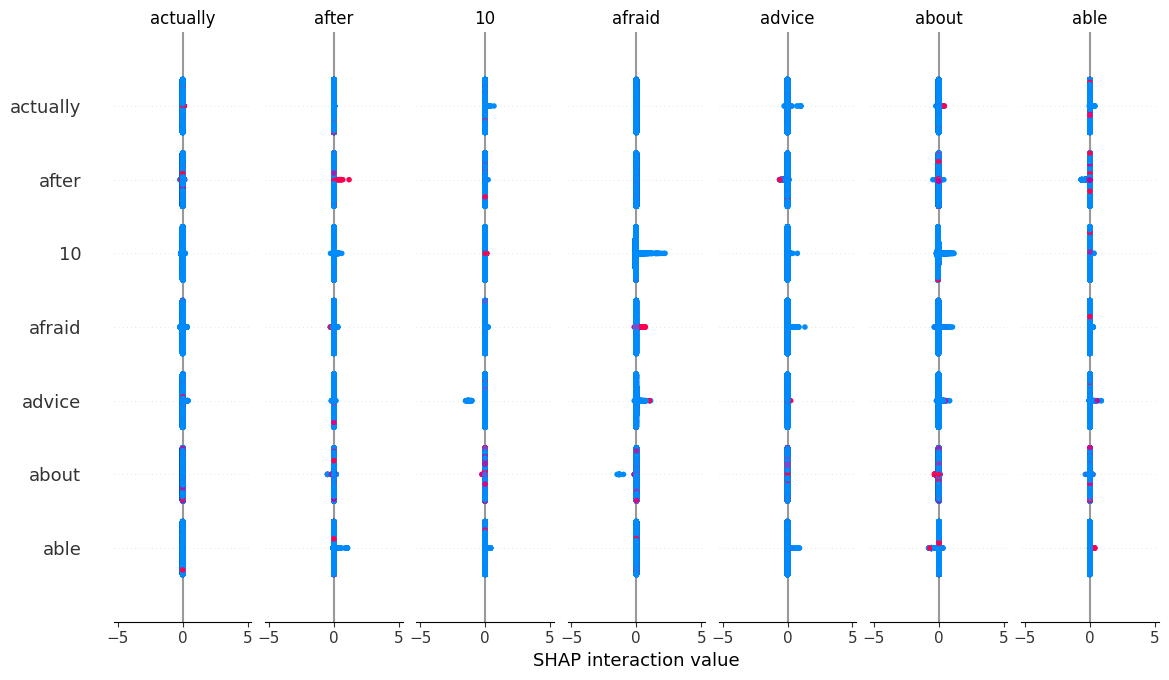

In [29]:
import numpy as np

# Ensure X_test is a NumPy array before passing to SHAP
shap.summary_plot(shap_values, np.array(X_test), feature_names=X_test.columns, show=False)

# Save the SHAP plot
plt.savefig("shap_summary_plot.png")
print("SHAP summary plot saved as shap_summary_plot.png")

Step 3: LLM Experimentation

In [30]:
import ollama  # Using Ollama LLM
import os
from fpdf import FPDF

In [31]:
# Function to get mental health explanations using Ollama
def get_mental_health_explanation(condition):
    """Generate explanation and coping strategies using Ollama LLM."""
    prompt = f"""
    The user has been diagnosed with {condition}.
    Provide natural language explanations for predicted mental health conditions. Also suggest coping mechanisms and potential next steps.
    """
    
    response = ollama.chat(model="mistral", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"]  # Ensure this correctly extracts the response

In [32]:
# Function to generate a PDF report
def save_report(condition, explanation):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    
    pdf.cell(200, 10, f"Mental Health Report for {condition}", ln=True, align="C")
    pdf.ln(10)
    
    pdf.multi_cell(0, 10, explanation)
    pdf.output(f"Mental_Health_Report_{condition}.pdf")

In [ ]:
# Process each condition in dataset
conditions = df['status'].unique()
for condition in conditions:
    explanation = get_mental_health_explanation(condition)  # Use Ollama LLM
    print(f"Explanation for {condition}:")
    print(explanation)
    
    # Save to PDF
    save_report(condition, explanation)